In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import mlflow
from revision_utils import TRACKING_URI, RUN_ASC3_W_RANKNET, RUN_ASC3_WO_RANKNET, FOLD_RESULTS_PICKLE

mlflow.set_tracking_uri(TRACKING_URI)

result_w_ranknet_path = mlflow.artifacts.download_artifacts(FOLD_RESULTS_PICKLE.format(run_id=RUN_ASC3_W_RANKNET))
result_wo_ranknet_path = mlflow.artifacts.download_artifacts(FOLD_RESULTS_PICKLE.format(run_id=RUN_ASC3_WO_RANKNET))

In [28]:
import os
import sys
from revision_utils import open_pickle, DATA_PATH

REV_DIR = os.getcwd()
RES_DIR = os.path.dirname(REV_DIR)
ROOT_DIR = os.path.dirname(RES_DIR)
sys.path.append(ROOT_DIR)

result_w_ranknet = open_pickle(result_w_ranknet_path)
result_wo_ranknet = open_pickle(result_wo_ranknet_path)
patient_dataset = open_pickle(DATA_PATH)

In [29]:
import os
import sys

import pandas as pd
revision_dir = os.getcwd()
result_dir = os.path.dirname(revision_dir)
root_dir = os.path.dirname(result_dir)

sys.path.append(root_dir)
from core.metric import Metric

rows = list()
method_names = ["3ASC W/ RankNet", "3ASC W/O RankNet"]
for method, method_result in zip(method_names, [result_w_ranknet, result_wo_ranknet]):
    for fold in range(0, 5):
        for k in [1, 2, 3, 4, 5, 10, 15, 20, 100]:
            snv_cnv_hit = Metric.topk_recall(
                bag_labels=method_result["fold_bag_y_trues"][fold],
                instance_labels=method_result["fold_instance_y_trues"][fold],
                instance_probs=method_result["fold_instance_y_probs"][fold],
                k=k,
                is_any=True
            )
            rows.append([method, fold, k, snv_cnv_hit])
            
snv_data = pd.DataFrame(rows, columns=["loss", "fold", "K", "HitRate@K\n(SNV+CNV)"])
snv_data.head()

,loss,fold,K,HitRate@K\n(SNV+CNV)
0,3ASC W/ RankNet,0,1,0.767342
1,3ASC W/ RankNet,0,2,0.895028
2,3ASC W/ RankNet,0,3,0.937999
3,3ASC W/ RankNet,0,4,0.960712
4,3ASC W/ RankNet,0,5,0.969920


In [30]:
from core.data_model import PatientDataSet
for method, method_result in zip(method_names, [result_w_ranknet, result_wo_ranknet]):
    all_fold_test_ids = method_result["test_ids"]
    for fold in range(0, 5):
        test_ids = all_fold_test_ids[fold]
        test_patient_dataset:PatientDataSet = patient_dataset[test_ids]
        
        bag_labels = list()
        instance_probs = list()
        instance_labels = list()
        instance_y_trues_at_fold = method_result["fold_instance_y_trues"][fold]
        instance_y_probs_at_fold = method_result["fold_instance_y_probs"][fold]
        for patient, instance_y_true, instance_y_probs  in zip(test_patient_dataset, instance_y_trues_at_fold, instance_y_probs_at_fold):
            if (patient.bag_label) == False \
                or (not patient.cnv_data.causal_variant) \
                or (not patient.snv_data.causal_variant != [("-", "-")]):
                    continue
                
            bag_labels.append(patient.bag_label)
            instance_labels.append(instance_y_true)
            instance_probs.append(instance_y_probs)
                
        for k in [1, 2, 3, 4, 5, 10, 15, 20, 100]:
            snv_cnv_hit = Metric.topk_recall(
                bag_labels=bag_labels,
                instance_labels=instance_labels,
                instance_probs=instance_probs,
                k=k,
                is_any=True
            )
            rows.append([method, fold, k, snv_cnv_hit])
            
cnv_data = pd.DataFrame(rows, columns=["loss", "fold", "K", "HitRate@K\n(CNV)"])
cnv_data.head()

,loss,fold,K,HitRate@K\n(CNV)
0,3ASC W/ RankNet,0,1,0.767342
1,3ASC W/ RankNet,0,2,0.895028
2,3ASC W/ RankNet,0,3,0.937999
3,3ASC W/ RankNet,0,4,0.960712
4,3ASC W/ RankNet,0,5,0.969920


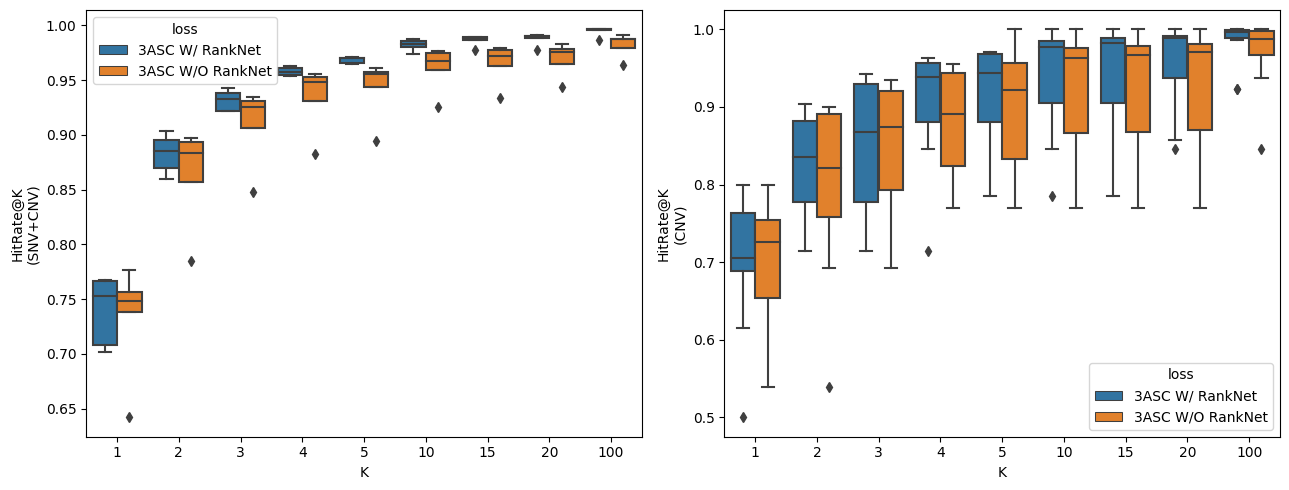

In [31]:
import seaborn as sns
from matplotlib import pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.boxplot(
    data=snv_data,
    x="K",
    y="HitRate@K\n(SNV+CNV)",
    hue="loss", 
    ax=axes[0]
)
sns.boxplot(
    data=cnv_data,
    x="K",
    y="HitRate@K\n(CNV)",
    hue="loss", 
    ax=axes[1]
)

plt.tight_layout()
plt.show()